## **Importowanie bibliotek**

Zaimportuj wszystkie niezbędne biblioteki do analizy danych, wizualizacji oraz budowy i trenowania modelu LSTM:

- **numpy** i **pandas** do przetwarzania i analizy danych,
- **matplotlib** do wizualizacji,
- **tensorflow** oraz **keras** do budowy sieci neuronowych,
- **yfinance** do pobierania danych finansowych z Yahoo Finance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import yfinance as yf

## **Pobieranie danych o cenach złota z Yahoo Finance**

Pobierz dane o cenach złota (np. ticker `GC=F`) z Yahoo Finance za pomocą biblioteki **yfinance** i wyodrębnij kolumnę `Close`. Wyświetl pierwsze wiersze pobranych danych, aby sprawdzić poprawność pobrania.

- **symbol** – ticker kontraktu terminowego na złoto,
- **data** – pobrane dane historyczne,
- **gold_prices** – ceny zamknięcia złota po usunięciu braków danych.

In [2]:
symbol = 'GC=F'
data = yf.download(symbol, start='2015-01-01', end=None)
gold_prices = data['Close'].dropna()
display(gold_prices.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,GC=F
Date,
2015-01-02,1186.000000
2015-01-05,1203.900024
2015-01-06,1219.300049
2015-01-07,1210.599976
2015-01-08,1208.400024


## **Wizualizacja historycznych cen złota**

W tej części przedstawiamy wykres przedstawiający zmiany cen zamknięcia złota na przestrzeni czasu. Dzięki wizualizacji możemy łatwo zaobserwować trendy, sezonowość oraz ewentualne nietypowe zmiany w danych historycznych. Oś X odpowiada dacie, a oś Y przedstawia cenę złota w dolarach amerykańskich (USD).

- Wykres liniowy prezentuje wartości z kolumny `Close` (ceny zamknięcia).
- Dodana legenda ułatwia interpretację wykresu.

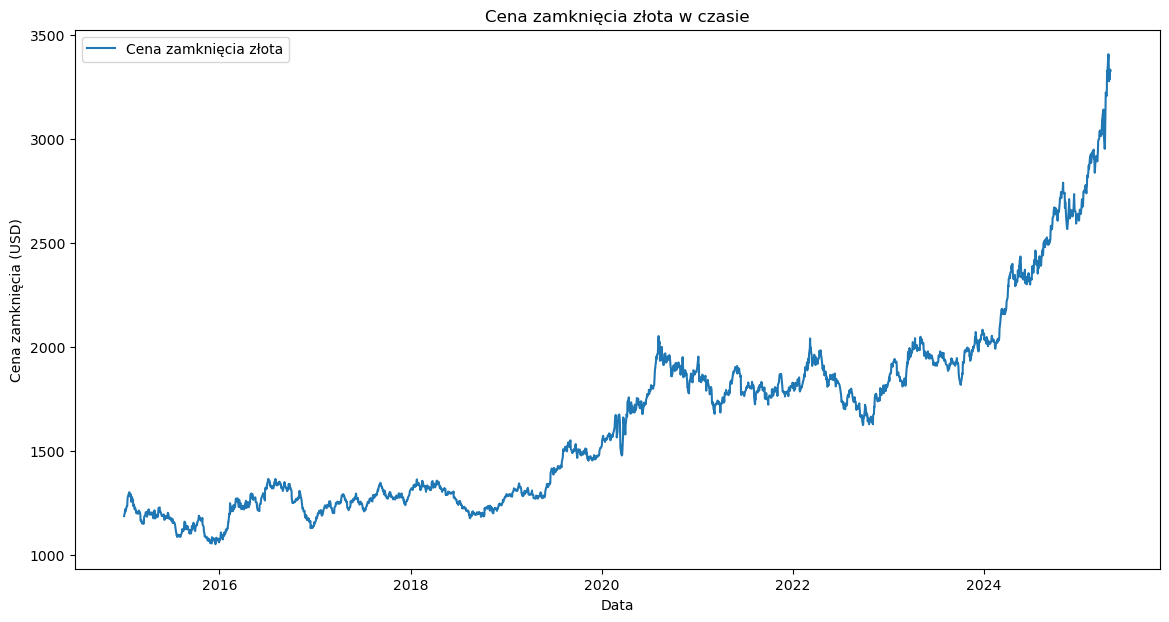

In [3]:
plt.figure(figsize=(14, 7))
plt.plot(gold_prices, label='Cena zamknięcia złota')
plt.title('Cena zamknięcia złota w czasie')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia (USD)')
plt.legend()
plt.show()

## **Przygotowanie danych do uczenia modelu LSTM**

W tej części przygotowujemy dane do trenowania modelu LSTM. Najpierw normalizujemy szereg czasowy cen złota do zakresu [0, 1] za pomocą skalera MinMaxScaler, co ułatwia uczenie sieci neuronowej. Następnie tworzymy sekwencje 7-dniowe, gdzie każda sekwencja służy do przewidywania ceny w kolejnym dniu. Dane dzielimy na zbiór treningowy i testowy w proporcji 80/20. Na końcu dopasowujemy kształt danych wejściowych do wymagań warstwy LSTM (dodajemy dodatkowy wymiar).

- **Normalizacja** – przekształcenie danych do zakresu [0, 1]  
- **Tworzenie sekwencji** – zamiana szeregu czasowego na próbki wejściowe i wyjściowe  
- **Podział danych** – rozdzielenie na zbiór treningowy i testowy  
- **Dopasowanie kształtu** – przygotowanie danych do wejścia w warstwę LSTM

In [5]:
def create_sequences(series, window_size = 7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(gold_prices.values.reshape(-1, 1)).flatten()

window_size = 7
X, y = create_sequences(scaled_prices, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train[... , np.newaxis]
X_test = X_test[... , np.newaxis]

print(f'Kształt X_train: {X_train.shape}')
print(f'Kształt y_train: {y_train.shape}')
print(f'Kształt X_test: {X_test.shape}')
print(f'Kształt y_test: {y_test.shape}')

Kształt X_train: (2069, 7, 1)
Kształt y_train: (2069,)
Kształt X_test: (518, 7, 1)
Kształt y_test: (518,)


## **Budowa modelu LSTM**

W tej części budujemy model sekwencyjny typu LSTM (Long Short-Term Memory) do prognozowania cen złota. Model składa się z warstwy LSTM, która umożliwia analizę sekwencji czasowych, oraz dwóch gęstych warstw (Dense), z których ostatnia generuje prognozowaną wartość ceny. Model kompilujemy z optymalizatorem Adam i funkcją straty MSE (średni błąd kwadratowy), co jest standardowym wyborem dla regresji.

- **Warstwa LSTM** – przetwarza sekwencje danych wejściowych,
- **Warstwy Dense** – przekształcają wyjście LSTM do pojedynczej prognozowanej wartości,
- **Kompilacja modelu** – ustawienie optymalizatora i funkcji straty.

In [8]:
model = keras.Sequential([
    layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

## **Trenowanie modelu**

W tej części trenujemy zbudowany model LSTM na przygotowanych danych. Proces uczenia odbywa się przez określoną liczbę epok, z wykorzystaniem podziału na zbiór treningowy i walidacyjny (10% danych treningowych służy do walidacji). Dzięki temu możemy monitorować postęp uczenia i sprawdzać, czy model nie przeucza się na danych treningowych.

- **epochs** – liczba epok uczenia (pełnych przejść przez zbiór treningowy),
- **batch_size** – liczba próbek w pojedynczej paczce danych,
- **validation_split** – procent danych treningowych użytych do walidacji,
- **verbose** – poziom szczegółowości wyświetlanych informacji podczas uczenia.

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0143 - val_loss: 2.5031e-04
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 3.2100e-04
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 1.4980e-04
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8198e-04 - val_loss: 1.8015e-04
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6023e-04 - val_loss: 7.9614e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.4889e-04 - val_loss: 1.5781e-04
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1216e-04 - val_loss: 1.5737e-04
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2163e-04 - val_loss: 2.0049e-04
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4622e-04 - val_loss: 1.4367e-04
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7212e-04 - val_loss: 6.2986e-04
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9701e-04 - val_loss: 5.1236e-

## **Predykcja i wizualizacja wyników**

W tej części wykonujemy predykcję cen złota na podstawie danych testowych przy użyciu wytrenowanego modelu LSTM. Następnie przekształcamy zarówno rzeczywiste, jak i prognozowane wartości z powrotem do oryginalnej skali cen (odwracając normalizację). Wyniki prezentujemy na wykresie, który pozwala porównać rzeczywiste ceny złota z prognozowanymi przez model.

- **y_pred** – prognozowane ceny przez model na zbiorze testowym,
- **y_test_inv** – rzeczywiste ceny po odwróceniu normalizacji,
- **y_pred_inv** – prognozowane ceny po odwróceniu normalizacji,
- Wykres umożliwia wizualną ocenę jakości prognoz modelu.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


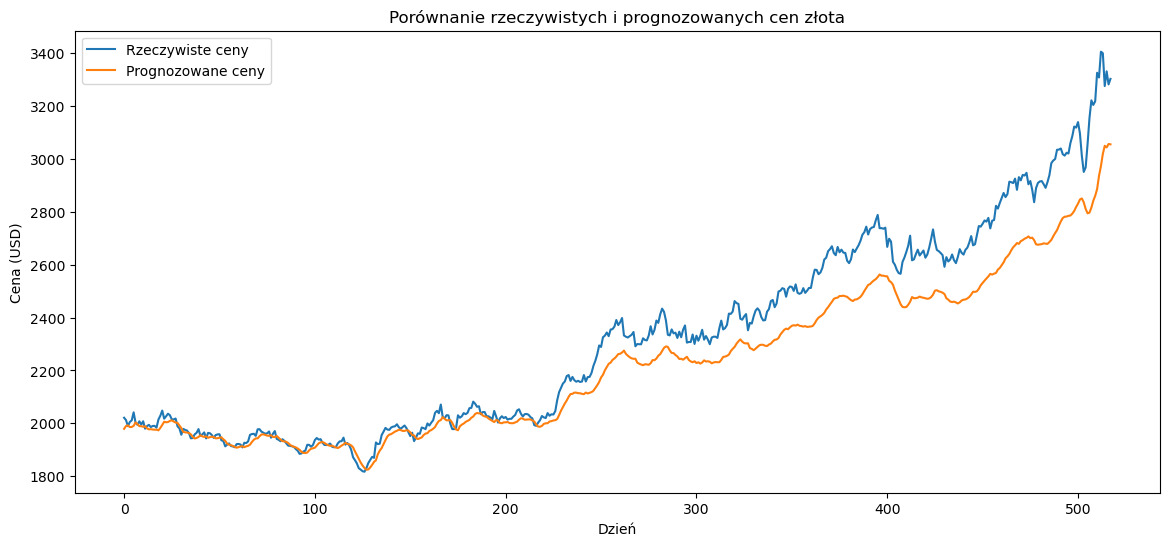

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

plt.figure(figsize=(14,6))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Rzeczywiste ceny')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Prognozowane ceny')
plt.title('Porównanie rzeczywistych i prognozowanych cen złota')
plt.xlabel('Dzień')
plt.ylabel('Cena (USD)')
plt.legend()
plt.show()

## **Prognoza ceny złota na najbliższy dzień**

W tej części prezentujemy prognozę ceny złota na kolejny dzień na podstawie ostatnich dostępnych danych oraz wytrenowanego modelu LSTM. Najpierw przygotowujemy listę ostatnich rzeczywistych cen oraz odpowiadających im dat. Następnie do tej listy dodajemy prognozowaną wartość na następny dzień i wyznaczamy nową datę. Wynik prezentujemy na wykresie, gdzie:

- Ostatnie rzeczywiste ceny są oznaczone linią z markerami,
- Prognoza na kolejny dzień jest wyróżniona kolorem czerwonym,
- Oś X przedstawia daty, a oś Y ceny złota w USD.

Na końcu wyświetlamy prognozowaną wartość w formie tekstowej.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


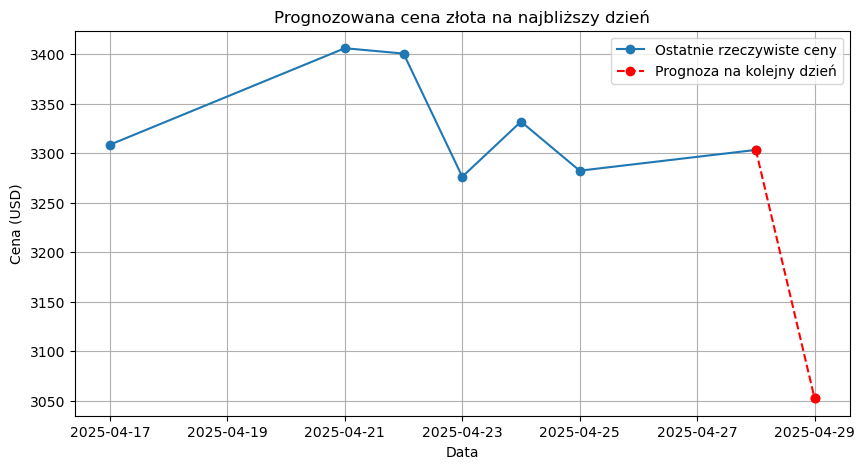

Prognozowana cena złota na najbliższy dzień: 3052.40 USD


In [ ]:
if isinstance(gold_prices, pd.DataFrame):
    gold_prices_series = gold_prices.squeeze()
else:
    gold_prices_series = gold_prices

last_days = gold_prices_series[-window_size:].values
last_days_scaled = scaler.transform(np.array(last_days).reshape(-1, 1)).flatten()
X_next = np.array(last_days_scaled).reshape(1, window_size, 1)
next_price_scaled = model.predict(X_next)[0][0]
next_price = scaler.inverse_transform([[next_price_scaled]])[0][0]

dates = gold_prices_series.index[-window_size:].tolist()
next_date = dates[-1] + pd.Timedelta(days=1)

last_days_plot = list(gold_prices_series[-window_size:])
last_days_plot.append(next_price)
dates_plot = dates + [next_date]

plt.figure(figsize=(10,5))
plt.plot(dates_plot[:-1], last_days_plot[:-1], marker='o', label='Ostatnie rzeczywiste ceny')
plt.plot([dates_plot[-2], dates_plot[-1]], [last_days_plot[-2], last_days_plot[-1]], 'ro--', label='Prognoza na kolejny dzień')
plt.scatter(dates_plot[-1], last_days_plot[-1], color='red', zorder=5)
plt.title('Prognozowana cena złota na najbliższy dzień')
plt.xlabel('Data')
plt.ylabel('Cena (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Prognozowana cena złota na najbliższy dzień: {next_price:.2f} USD")